In [1]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier

from pyts.classification import *

from sktime.classification.sklearn import RotationForest
from sktime.classification.compose import ComposableTimeSeriesForestClassifier
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.deep_learning.fcn import FCNClassifier
from sktime.classification.deep_learning.mlp import MLPClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtesting.test import EURUSD, SMA
import pmdarima as pm

from tensorflow.keras.optimizers.legacy import Adam
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC

# from talib import RSI, STOCH, MACD, ADX 
# from finta import TA 
# from finta.TA import AROON


data = EURUSD.copy()
data


# data = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD/EURUSD_H1_200702210000_202304242100.tsv')
# # remove the following columns <TICKVOL>, <VOL> and <SPREAD>
# data = data.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
# # rename the columns
# data = data.rename(columns={'<DATE>': 'Date',
#                                 '<TIME>': 'Time',
#                                 '<OPEN>': 'Open',
#                                 '<HIGH>': 'High',
#                                 '<LOW>': 'Low',
#                                 '<CLOSE>': 'Close'})
# # combine the date and time columns
# data['Date_Time'] = data['Date'] + ' ' + data['Time']
# # convert the date_time column to datetime
# data['Date_Time'] = pd.to_datetime(data['Date_Time'], format='%Y%m%d %H:%M:%S.%f')
# # remove the date and time columns
# data = data.drop(['Date', 'Time'], axis=1)
# data.index = data['Date_Time']


def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Volume-derived features
# data['X_VMA10'] = data.Volume.rolling(10).mean() 
# data['X_VMA20'] = data.Volume.rolling(20).mean() 
# data['X_VMA50'] = data.Volume.rolling(50).mean() 
# data['X_VMA100'] = data.Volume.rolling(100).mean()

# data['X_VOL10'] = (data.Volume - data.X_VMA10) / data.Volume 
# data['X_VOL20'] = (data.Volume - data.X_VMA20) / data.Volume 
# data['X_VOL50'] = (data.Volume - data.X_VMA50) / data.Volume 
# data['X_VOL100'] = (data.Volume - data.X_VMA100) / data.Volume


# # Indicator features
# data['X_MOM'] = data.Close.pct_change(periods=2)
# data['X_BB_upper'] = (upper - close) / close
# data['X_BB_lower'] = (lower - close) / close
# data['X_BB_width'] = (upper - lower) / close
# data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

# data = data.dropna()
data = data.dropna().astype(float)


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    # Devalue returns smaller than 0.4%
    y[y.between(-.004, .004)] = 0
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y



X, y = get_clean_Xy(data)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=.5, random_state=0)

In [2]:
class ClassificationBaseline:
    """Baseline model that always predicts the most frequent class"""
    def fit(self,X, y):
        train_labels = y
        train_label_counts = pd.Series(train_labels).value_counts()
        self.featureless_pred_label = train_label_counts.idxmax()

    def predict(self, X):
        test_features = X
        test_nrow, test_ncol = test_features.shape
        return np.repeat(self.featureless_pred_label, test_nrow)

In [ ]:
data

In [9]:

classifier_list = [
    # Algorithms from scikit-learn
    {
        'name': 'KNeighborsClassifier',
        'algo': KNeighborsClassifier(7),
        'library': 'sklearn'
    },
    {
        'name': 'LogisticRegressionCV',
        'algo': LogisticRegressionCV(max_iter=100_000, cv=5, random_state=0),
        'library': 'sklearn'
    },
    {
        'name': 'DecisionTreeClassifier',
        'algo': DecisionTreeClassifier(random_state=0),
        'library': 'sklearn'
    },
    {
        'name': 'MLPClassifier',
        'algo': MLPClassifier(),
        'library': 'sklearn',
    },
    {
        'name': 'RidgeClassifierCV',
        'algo': RidgeClassifierCV(),
        'library': 'sklearn',
    },
    # Algorithms from PyTorch
    {
        'name': 'LearningShapelets',
        'algo': LearningShapelets(),
        'library': 'pyts',
    },
    {
        'name': 'BOSSVS',
        'algo': BOSSVS(),
        'library': 'pyts',
    },
    {
        'name': 'KNeighborsClassifier',
        'algo': KNeighborsClassifier(),
        'library': 'pyts',
    },
    {
        'name': 'TimeSeriesForest',
        'algo': TimeSeriesForest(),
        'library': 'pyts',
    },
    # Algorithms from sktime
    {
        'name': 'ComposableTimeSeriesForestClassifier',
        'algo': ComposableTimeSeriesForestClassifier(),
        'library': 'sktime',
    },
    {
        'name': 'RotationForest',
        'algo': RotationForest(),
        'library': 'sktime',
    },

    {
        'name': 'CNNClassifier',
        'algo': CNNClassifier(n_epochs=20, batch_size=4),
        'library': 'sktime',
    },
    {
        'name': 'FCNClassifier',
        'algo': FCNClassifier(n_epochs=20, batch_size=4),
        'library': 'sktime',
    },
    {
        'name': 'MLPClassifier',
        'algo': MLPClassifier(n_epochs=20, batch_size=4),
        'library': 'sktime',
    },
    # Algorithms from tslearn
    {
        'name': 'ClassificationBaseline',
        'algo': ClassificationBaseline(),
        'library': 'rat'
    },

]

classifier_list = [
    # Algorithms from scikit-learn
    # {
    #     'name': 'sklearn_KNeighborsClassifier',
    #     'algo': KNeighborsClassifier(7),
    #     'library': 'sklearn'
    # },
    # {
    #     'name': 'sklearn_RidgeCV',
    #     'algo': RidgeCV(),
    #     'library': 'sklearn'
    # },
    #    {
    #     'name': 'sktime_CNNClassifier',
    #     'algo': CNNClassifier(n_epochs=20, batch_size=4),
    #     'library': 'sktime',
    # },
    # {
    #     'name': 'sktime_FCNClassifier',
    #     'algo': FCNClassifier(n_epochs=20, batch_size=4),
    #     'library': 'sktime',
    # },
    # {
    #     'name': 'rat_ClassificationBaseline',
    #     'algo': ClassificationBaseline(),
    #     'library': 'rat'
    # },
    {
        'name': 'sktime_MLPClassifier',
        'algo': MLPClassifier(optimizer=Adam(), n_epochs=20, batch_size=4),
        'library': 'sktime',
    },
    {
        'name': 'LearningShapelets',
        'algo': LearningShapelets(),
        'library': 'pyts',
    },
    {
        'name': 'ClassificationBaseline',
        'algo': ClassificationBaseline(),
        'library': 'rat'
    },
]

pred_score_list = []
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None)

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    # for every algo in the list of classifiers, fit the algo and predict on the test set
    for algorithm in classifier_list:
        my_classifier = algorithm['algo']
        my_classifier.fit(X_train, y_train)
        y_pred = my_classifier.predict(X_test)

        pred_score_list.append(pd.DataFrame({
            'accuracy': accuracy_score(y_test, y_pred),
            # 'f1' : f1_score(y_test, y_pred),
            # 'precision' : precision_score(y_test, y_pred, average='macro'),
            # 'recall' : recall_score(y_test, y_pred, average='macro'),
            'split': i+1,
            'algorithm': algorithm['name'],
            'library': algorithm['library'],
        }, index=[0]))

# Combine the results into a single dataframe
pred_score_df = pd.concat(pred_score_list)


243/243 [==============================] - 0s 422us/step


In [ ]:
pred_score_df

In [ ]:
import matplotlib.pyplot as plt

# Import seaborn
import seaborn as sns

# Plot a bar plot of accuracy by split and algo using catplot
g = sns.catplot(x="split", y="accuracy", hue="algorithm", data=pred_score_df, kind="bar")
g.set_axis_labels("Split", "Accuracy")
g.fig.suptitle("Accuracy by Split and Algorithm")
plt.show()

In [ ]:
# Import pandas and seaborn for plotting
import pandas as pd
import seaborn as sns
import plotnine as p9

# Create a facet grid with library as columns and algorithm as rows
g = sns.FacetGrid(pred_score_df, col="library", row="algorithm")

# Map a scatter plot of accuracy to each facet
g.map(sns.scatterplot, "accuracy")

# Adjust the titles and labels
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_xlabels("Accuracy")
g.set_ylabels("")

# Show the plot
plt.show()

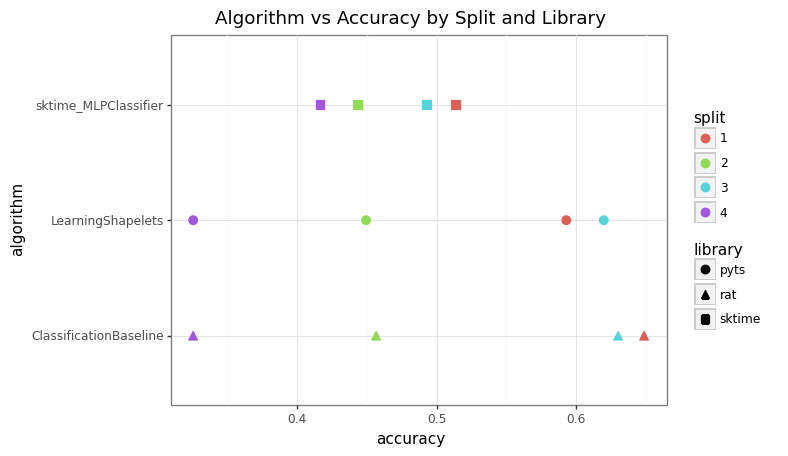

In [10]:
import plotnine as p9
# Convert split to a categorical type
pred_score_df["split"] = pd.Categorical(pred_score_df["split"])
gg = p9.ggplot() +\
    p9.geom_point(
        p9.aes(
            x="accuracy",
            y="algorithm",
            color="split",
            shape="library",
        ),
        data=pred_score_df,
        size=3,
        )+\
p9.ggtitle("Algorithm vs Accuracy by Split and Library")+\
p9.theme_bw()
print(gg)    

In [ ]:
pred_score_df

In [ ]:
data = data.dropna()

In [5]:
data
# use Yeo-Johnson transform from sklearn
from sklearn.preprocessing import PowerTransformer

ohlc_columns = data.columns

pt = PowerTransformer(method='yeo-johnson', standardize=True)
pt.fit(data)

# Transform the OHLC data
ohlc_data_transformed = pt.transform(data)

# Convert the transformed data to a dataframe
ohlc_df_transformed = pd.DataFrame(ohlc_data_transformed, columns=ohlc_columns)

X, y = get_clean_Xy(ohlc_df_transformed)



In [6]:
data

,Open,High,Low,Close,Volume,X_SMA10,X_SMA20,X_SMA50,X_SMA100,X_DELTA_SMA10,X_DELTA_SMA20,X_DELTA_SMA50,X_day,X_hour
2017-04-25 12:00:00,1.08879,1.08962,1.08866,1.08890,1005.0,0.000934,0.001711,0.005324,0.010199,0.000777,0.003613,0.004875,1.0,12.0
2017-04-25 13:00:00,1.08888,1.09016,1.08797,1.09000,1340.0,0.001577,0.002481,0.005945,0.011034,0.000904,0.003463,0.005090,1.0,13.0
2017-04-25 14:00:00,1.08997,1.09328,1.08902,1.09281,3642.0,0.003550,0.004726,0.008085,0.013392,0.001176,0.003359,0.005307,1.0,14.0
2017-04-25 15:00:00,1.09284,1.09412,1.09198,1.09409,1651.0,0.004024,0.005558,0.008800,0.014344,0.001533,0.003243,0.005544,1.0,15.0
2017-04-25 16:00:00,1.09407,1.09499,1.09386,1.09492,966.0,0.004172,0.005938,0.009074,0.014882,0.001766,0.003136,0.005808,1.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203.0,-0.001970,-0.002386,-0.002976,-0.006345,-0.000416,-0.000590,-0.003369,2.0,11.0
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325.0,-0.002280,-0.002871,-0.003423,-0.006920,-0.000591,-0.000552,-0.003496,2.0,12.0
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824.0,-0.002291,-0.003059,-0.003651,-0.007239,-0.000768,-0.000592,-0.003589,2.0,13.0
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065.0,-0.001483,-0.002393,-0.003053,-0.006728,-0.000909,-0.000660,-0.003675,2.0,14.0


In [ ]:
from typing import List, Generator
import numpy as np
from sklearn.model_selection._split import _BaseKFold
from sklearn.utils.validation import indexable, _num_samples


class MonteCarloCV(_BaseKFold):

    def __init__(self,
                 n_splits: int,
                 train_size: float,
                 test_size: float,
                 gap: int = 0):
        """
        Monte Carlo Cross-Validation

        Holdout applied in multiple testing periods
        Testing origin (time-step where testing begins) is randomly chosen according to a monte carlo simulation

        :param n_splits: (int) Number of monte carlo repetitions in the procedure
        :param train_size: (float) Train size, in terms of ratio of the total length of the series
        :param test_size: (float) Test size, in terms of ratio of the total length of the series
        :param gap: (int) Number of samples to exclude from the end of each train set before the test set.
        """

        self.n_splits = n_splits
        self.n_samples = -1
        self.gap = gap
        self.train_size = train_size
        self.test_size = test_size
        self.train_n_samples = 0
        self.test_n_samples = 0

        self.mc_origins = []

    def split(self, X, y=None, groups=None) -> Generator:
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """

        X, y, groups = indexable(X, y, groups)
        self.n_samples = _num_samples(X)

        self.train_n_samples = int(self.n_samples * self.train_size) - 1
        self.test_n_samples = int(self.n_samples * self.test_size) - 1

        # Make sure we have enough samples for the given split parameters
        if self.n_splits > self.n_samples:
            raise ValueError(
                f'Cannot have number of folds={self.n_splits} greater'
                f' than the number of samples={self.n_samples}.'
            )
        if self.train_n_samples - self.gap <= 0:
            raise ValueError(
                f'The gap={self.gap} is too big for number of training samples'
                f'={self.train_n_samples} with testing samples={self.test_n_samples} and gap={self.gap}.'
            )

        indices = np.arange(self.n_samples)

        selection_range = np.arange(self.train_n_samples + 1, self.n_samples - self.test_n_samples - 1)

        self.mc_origins = \
            np.random.choice(a=selection_range,
                             size=self.n_splits,
                             replace=True)

        for origin in self.mc_origins:
            if self.gap > 0:
                train_end = origin - self.gap + 1
            else:
                train_end = origin - self.gap
            train_start = origin - self.train_n_samples - 1

            test_end = origin + self.test_n_samples

            yield (
                indices[train_start:train_end],
                indices[origin:test_end],
            )

    def get_origins(self) -> List[int]:
        return self.mc_origins